# Importing Libraries:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

import statsmodels.api as sm
% matplotlib inline

UsageError: Line magic function `%` not found.


# Reading Dataset:

In [3]:
dataset=pd.read_excel("https://community.tableau.com/servlet/JiveServlet/downloadBody/1236-102-2-15278/Sample%20-%20Superstore.xlsx")
dataset.head()


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [4]:
dataset.dtypes

Row ID                    int64
Order ID                 object
Order Date       datetime64[ns]
Ship Date        datetime64[ns]
Ship Mode                object
Customer ID              object
Customer Name            object
Segment                  object
Country                  object
City                     object
State                    object
Postal Code               int64
Region                   object
Product ID               object
Category                 object
Sub-Category             object
Product Name             object
Sales                   float64
Quantity                  int64
Discount                float64
Profit                  float64
dtype: object

In [5]:
set(dataset['Category'])

{'Furniture', 'Office Supplies', 'Technology'}

# Data Preprocessing:

First analyzing the time series of Furniture Sales followed by other categories.

In [6]:
furniture = dataset.loc[dataset['Category'] == 'Furniture']


print(furniture['Order Date'].min())
furniture['Order Date'].max()

2014-01-06 00:00:00


Timestamp('2017-12-30 00:00:00')

This shows that we have time-series data of 4 years for furniture sales.

In [7]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City',
        'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity',
        'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)

C:\Users\AKANSHA BHATT\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [8]:
furniture.sort_values('Order Date')
#Checking null values:
furniture.isna().sum()

Order Date    0
Sales         0
dtype: int64

In [9]:
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()

# Indexing time-series data:

In [10]:
furniture = furniture.set_index('Order Date')
#furniture = furniture.apply(lambda x: x.set_index('Order Date'))
furniture.index

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-14', '2014-01-16', '2014-01-19',
               '2014-01-20', '2014-01-21',
               ...
               '2017-12-18', '2017-12-19', '2017-12-21', '2017-12-22',
               '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=889, freq=None)

In [11]:
# Averaging Daily Sales
y = furniture['Sales'].resample('MS').mean()

In [12]:
y['2017':]

Order Date
2017-01-01     397.602133
2017-02-01     528.179800
2017-03-01     544.672240
2017-04-01     453.297905
2017-05-01     678.302328
2017-06-01     826.460291
2017-07-01     562.524857
2017-08-01     857.881889
2017-09-01    1209.508583
2017-10-01     875.362728
2017-11-01    1277.817759
2017-12-01    1256.298672
Freq: MS, Name: Sales, dtype: float64

# Furniture data time-series visualization

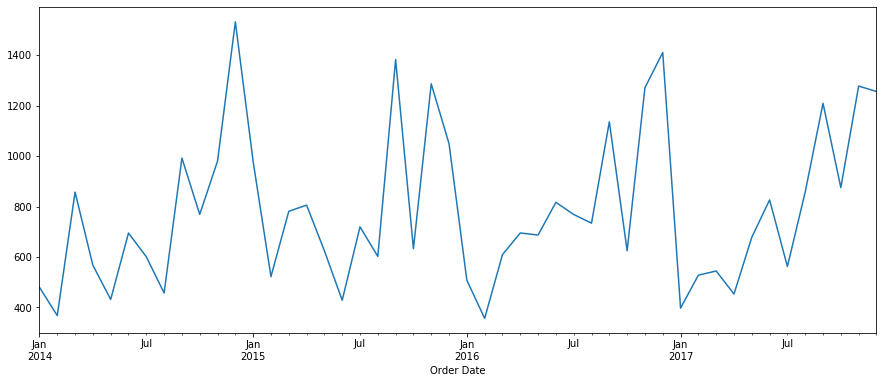

In [13]:
y.plot(figsize=(15, 6))

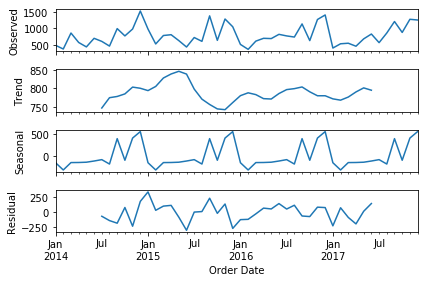

In [14]:
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
decomposition.plot()
plt.show()

The above plot shows that the sales of furniture is highly unstable with seasonality and trend.

# Time Series forecasting with ARIMA Model

Configuring a SARIMA requires selecting hyperparameters for both the trend and seasonal components of the series.

Trend Components:

p denotes Trend autoregression order,
d denotes Trend difference order,
q denotes Trend moving average order,

Seasonality Components:

p denotes Seasonal autoregressive order.
d denotes Seasonal difference order.
q denotes Seasonal moving average order.
m denotes the number of time steps for a single seasonal period

In [16]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

print('Few parameter combinations are:')
print('{} x {}'.format(pdq[1], seasonal_pdq[1]))
print('{} x {}'.format(pdq[2], seasonal_pdq[2]))

Few parameter combinations are:
(0, 0, 1) x (0, 0, 1, 12)
(0, 1, 0) x (0, 1, 0, 12)


Now that all possible parameters are generated for our SARIMA model,lets find out the best parameter to train the model on it finally.

SARIMA stands for Seasonal AutoRegressive Integrated Moving Average model which is an extension of ARIMA model used in modeling the seasonality component as well. So, no need to make time-series stationary (non-seasonal) first before forecasting.

In [17]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = sm.tsa.statespace.SARIMAX(y, order=param, seasonal_order=param_seasonal, enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = model.fit()
            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

C:\Users\AKANSHA BHATT\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


ARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:769.0817523205916


C:\Users\AKANSHA BHATT\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:1479.4798443994346
ARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:477.71701309202774
ARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:497.2314433418337


C:\Users\AKANSHA BHATT\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:1050.7228724636502
ARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:318.0047199116341
ARIMA(0, 0, 1)x(0, 0, 0, 12) - AIC:720.9252270758122


C:\Users\AKANSHA BHATT\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(0, 0, 1, 12) - AIC:2729.707377918614
ARIMA(0, 0, 1)x(0, 1, 0, 12) - AIC:466.56074298091573


C:\Users\AKANSHA BHATT\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(1, 0, 0, 12) - AIC:499.6027670716122


C:\Users\AKANSHA BHATT\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(1, 0, 1, 12) - AIC:nan
ARIMA(0, 0, 1)x(1, 1, 0, 12) - AIC:319.98848769468674
ARIMA(0, 1, 0)x(0, 0, 0, 12) - AIC:677.8947668259311


C:\Users\AKANSHA BHATT\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(0, 0, 1, 12) - AIC:1516.5426763100618
ARIMA(0, 1, 0)x(0, 1, 0, 12) - AIC:486.63785671879367
ARIMA(0, 1, 0)x(1, 0, 0, 12) - AIC:497.78896630044073


C:\Users\AKANSHA BHATT\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(1, 0, 1, 12) - AIC:1266.6752010109617
ARIMA(0, 1, 0)x(1, 1, 0, 12) - AIC:319.7714068109212
ARIMA(0, 1, 1)x(0, 0, 0, 12) - AIC:649.9056176816877


C:\Users\AKANSHA BHATT\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(0, 0, 1, 12) - AIC:nan
ARIMA(0, 1, 1)x(0, 1, 0, 12) - AIC:458.87055484828454
ARIMA(0, 1, 1)x(1, 0, 0, 12) - AIC:486.1832977442842
ARIMA(0, 1, 1)x(1, 0, 1, 12) - AIC:3025.1111407028534
ARIMA(0, 1, 1)x(1, 1, 0, 12) - AIC:310.75743684172227
ARIMA(1, 0, 0)x(0, 0, 0, 12) - AIC:692.1645522067712
ARIMA(1, 0, 0)x(0, 0, 1, 12) - AIC:1485.0761237310433
ARIMA(1, 0, 0)x(0, 1, 0, 12) - AIC:479.46321478521355
ARIMA(1, 0, 0)x(1, 0, 0, 12) - AIC:480.92593679352007


C:\Users\AKANSHA BHATT\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(1, 0, 1, 12) - AIC:1066.9240091304332
ARIMA(1, 0, 0)x(1, 1, 0, 12) - AIC:304.46646750846
ARIMA(1, 0, 1)x(0, 0, 0, 12) - AIC:665.7794442185758
ARIMA(1, 0, 1)x(0, 0, 1, 12) - AIC:1269123.2964480466
ARIMA(1, 0, 1)x(0, 1, 0, 12) - AIC:468.36851958151624
ARIMA(1, 0, 1)x(1, 0, 0, 12) - AIC:482.5763323876914
ARIMA(1, 0, 1)x(1, 0, 1, 12) - AIC:13913.985400443167
ARIMA(1, 0, 1)x(1, 1, 0, 12) - AIC:306.01560021700993
ARIMA(1, 1, 0)x(0, 0, 0, 12) - AIC:671.2513547541903


C:\Users\AKANSHA BHATT\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(0, 0, 1, 12) - AIC:1312.1454042552252
ARIMA(1, 1, 0)x(0, 1, 0, 12) - AIC:479.20034222811347
ARIMA(1, 1, 0)x(1, 0, 0, 12) - AIC:475.34036587839495


C:\Users\AKANSHA BHATT\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(1, 0, 1, 12) - AIC:1116.151994342978
ARIMA(1, 1, 0)x(1, 1, 0, 12) - AIC:300.6270901345403
ARIMA(1, 1, 1)x(0, 0, 0, 12) - AIC:649.03180198352
ARIMA(1, 1, 1)x(0, 0, 1, 12) - AIC:2452.5743966418013
ARIMA(1, 1, 1)x(0, 1, 0, 12) - AIC:460.47626876099923
ARIMA(1, 1, 1)x(1, 0, 0, 12) - AIC:469.5250354660704
ARIMA(1, 1, 1)x(1, 0, 1, 12) - AIC:3542427.3323914655
ARIMA(1, 1, 1)x(1, 1, 0, 12) - AIC:297.787543953891


The lowest AIC value: 297.788 for ARIMA(1, 1, 1)x(1, 1, 0, 12) and can use these best params in our model.

Akaike information criterion (AIC) is an estimator of the relative quality of statistical models for a given set of data. Given a collection of models for the data, AIC estimates the quality of each model, relative to each of the other models. Thus, AIC provides a means for model selection.

AIC estimates the relative amount of information lost by a given model: the less information a model loses (less AIC value), the higher the quality of that model.

In [18]:
# Training the ARIMA model.
model = sm.tsa.statespace.SARIMAX(y, order=(1, 1, 1), seasonal_order=(1, 1, 0, 12), enforce_stationarity=False,
                                            enforce_invertibility=False)
results = model.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0146      0.342      0.043      0.966      -0.655       0.684
ma.L1         -1.0000      0.360     -2.781      0.005      -1.705      -0.295
ar.S.L12      -0.0253      0.042     -0.609      0.543      -0.107       0.056
sigma2      2.958e+04   1.22e-05   2.43e+09      0.000    2.96e+04    2.96e+04


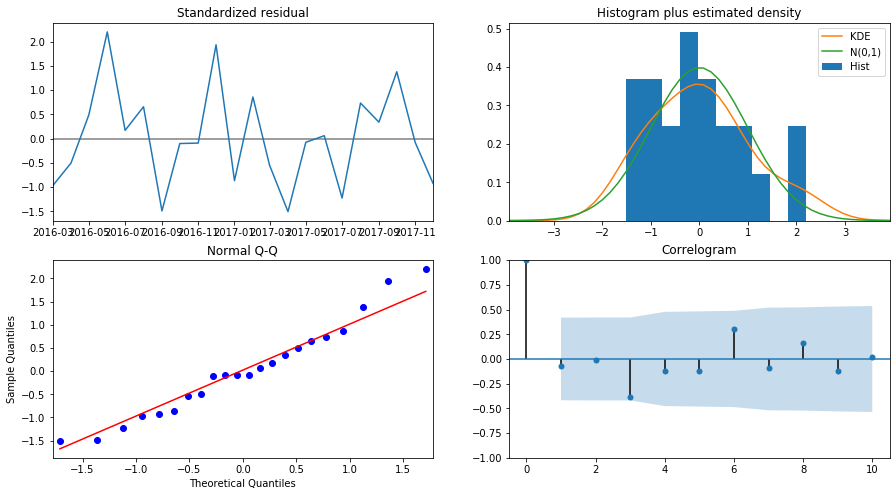

In [19]:
results.plot_diagnostics(figsize=(15, 8))
plt.show()



The above plots suggest that the Model Residuals are nearly Normally Distributed.

# Validating the model forecasts

To validate the model results, we compare the actual sales with the predicted sales of the time series data starting from 2017/01/01 till the end of the data.

            lower Sales  upper Sales
Order Date                          
2017-01-01   204.676132   895.517988
2017-02-01    31.859704   721.912970
2017-03-01   296.216001   985.551798
2017-04-01   373.138117  1061.818358
2017-05-01   347.351493  1035.430406
2017-06-01   471.969220  1159.494573
2017-07-01   433.445435  1120.459521
2017-08-01   385.912344  1072.452786
2017-09-01   806.828538  1492.928954
2017-10-01   291.097918   976.788469
2017-11-01   948.687529  1633.995378
2017-12-01  1074.694496  1759.644191


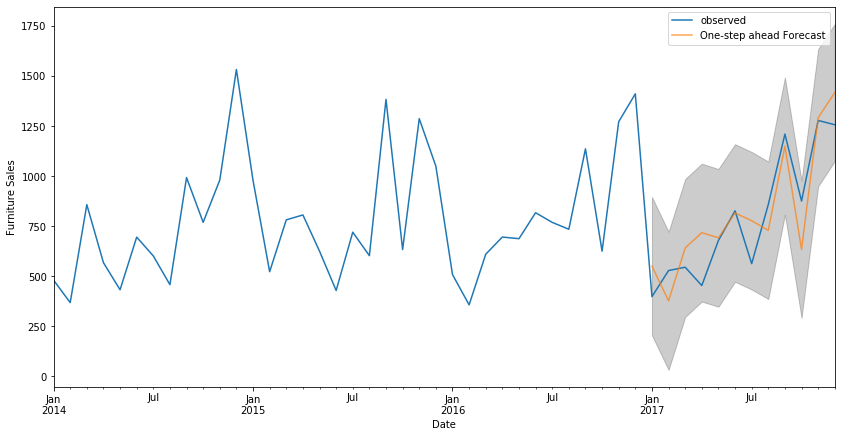

In [20]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
print(pred_ci)
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

The above plot demonstrates that the predicted values alligns well with the true values capturing an upward seasonality. Now, we calculate the Mean Square Error of our predicted values wrt the orignal values.

In [21]:
y_predicted = pred.predicted_mean
y_true = y['2017-01-01':]
mse = ((y_predicted - y_true)**2).mean()
print('Mean Square Error is:', round(mse, 4))

Mean Square Error is: 22993.5708


In [22]:
print('Root Mean Square Error is:', np.sqrt(mse))

Root Mean Square Error is: 151.63631091658434


# Future Forecasts:

C:\Users\AKANSHA BHATT\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


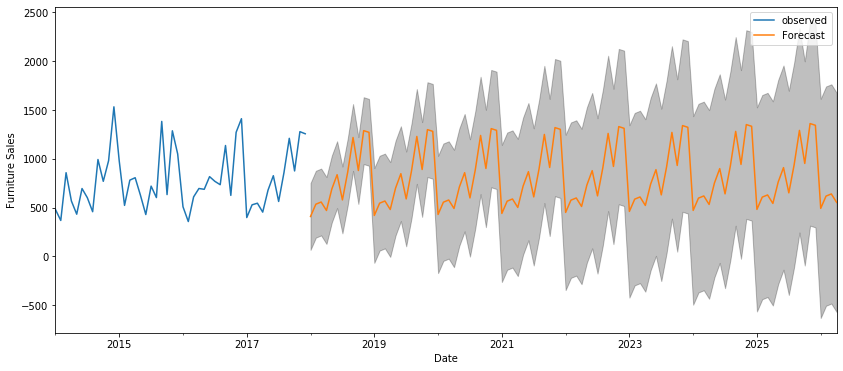

In [23]:
# Forecasting the future (out of sample) values.
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 6))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

The confidence interval is increasing as we move further into the future. The model becomes less confident in predicting the values as we move ahead.

Our data has 3 categories: 'Furniture', 'Office Supplies' and, 'Technology'. Let's compare the 'Furniture' and 'Office Supplies' time series.

# Furniture vs Office Supplies:

In [24]:
furniture = dataset.loc[dataset['Category'] == 'Furniture']
office = dataset.loc[dataset['Category'] == 'Office Supplies']
furniture.shape, office.shape

((2121, 21), (6026, 21))

In [25]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
office.drop(cols, axis=1, inplace=True)

furniture = furniture.sort_values('Order Date')
office = office.sort_values('Order Date')

furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
office = office.groupby('Order Date')['Sales'].sum().reset_index()

furniture = furniture.set_index('Order Date')
office = office.set_index('Order Date')

y_furniture = furniture['Sales'].resample('MS').mean()
y_office = office['Sales'].resample('MS').mean()

furniture = pd.DataFrame({'Order Date':y_furniture.index, 'Sales':y_furniture.values})
office = pd.DataFrame({'Order Date': y_office.index, 'Sales': y_office.values})

C:\Users\AKANSHA BHATT\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Now, let's merge both the time series for comparison.

In [26]:
store = furniture.merge(office, on='Order Date', how='inner')
store.rename(columns={'Sales_x': 'Furniture Sales', 'Sales_y': 'Office Sales'}, inplace=True)
store.head()

,Order Date,Furniture Sales,Office Sales
0,2014-01-01,480.194231,285.357647
1,2014-02-01,367.931600,63.042588
2,2014-03-01,857.291529,391.176318
3,2014-04-01,567.488357,464.794750
4,2014-05-01,432.049188,324.346545


# Visualizing Furniture vs Office Sales time series:

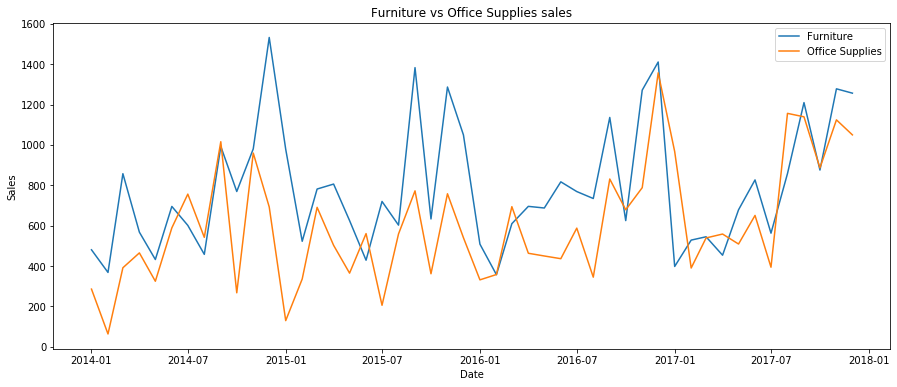

In [27]:
plt.figure(figsize=(15, 6))
plt.plot(store['Order Date'], store['Furniture Sales'], label='Furniture')
plt.plot(store['Order Date'], store['Office Sales'], label='Office Supplies')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Furniture vs Office Supplies sales')
plt.legend()

# Few Observations:

The above plot clearly shows that both furniture and office supplies exhibit similar seasonality component.
The sales are generally low at the beginning of every year as evident from decreasing line slope at the onset of year 2014, 2015, 2016 etc.
Also, monthly average sales of furniture is higher than that of office supplies. It's probably because cost of furniture is much more as compared to office utilities.
But there are few instances in the time series where office supply sales surpass furniture. It is mainly in July 2014 for the first time in the dataset.